In [1]:
import os
import re
import warnings
import pandas as pd
from PIL import Image, ImageFile
from tqdm import tqdm
from tqdm.auto import tqdm as tqdm_auto
from tabulate import tabulate
import gc
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence
from torch.cuda.amp import autocast

from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from transformers import (CLIPProcessor, CLIPModel,Qwen2VLForConditionalGeneration, AutoProcessor)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    cohen_kappa_score,
    classification_report,
    matthews_corrcoef,
    log_loss,
    balanced_accuracy_score,
    average_precision_score
)


warnings.filterwarnings("ignore", message="Palette images with Transparency expressed in bytes should be converted to RGBA images")
ImageFile.LOAD_TRUNCATED_IMAGES = True
%matplotlib inline

2025-08-10 14:41:09.573247: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754836869.598028     352 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754836869.605003     352 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df1=pd.read_csv("/kaggle/input/english-fake-news-dataset/enclean_fake_news.csv")
df2=pd.read_csv("/kaggle/input/bengali-fake-news-dataset/cleanbn_fakenews.csv", encoding='utf-8-sig')

In [3]:
df = pd.concat([df1, df2], ignore_index=True)

In [4]:
df.head()

,label,text
0,1,wow huckabee ask nancy pelosi if shes racist o...
1,1,wikileaks why be the clinton scooby van fit wi...
2,1,thai government take action against monk over ...
3,1,responsible gun owner who have never fire one ...
4,1,stark und schön zugleich stark und schön zugle...


In [5]:
mode=df["text"].mode()[0]
df["text"]=df["text"].fillna(mode)

In [6]:
df.shape

(22948, 2)

In [7]:
df.isnull().sum()

label    0
text     0
dtype: int64

In [8]:
image_dir="/kaggle/input/multilingual-fake-news-images-bn-en/selected_images/"


In [9]:
def is_valid_image(path):
    try:
        with Image.open(path) as img:
            img.verify()
        return True
    except Exception:
        return False

def collect_images(label, image_dir):
    image_paths = []
    lang_counts = {"bn": 0, "en": 0}
    for lang in ["bn", "en"]:
        lang_dir = os.path.join(image_dir, label, lang)
        if not os.path.exists(lang_dir):
            continue
        folders = [f for f in os.listdir(lang_dir) if os.path.isdir(os.path.join(lang_dir, f))]
        for folder in tqdm(folders, desc=f"{label.upper()}-{lang.upper()}"):
            folder_path = os.path.join(lang_dir, folder)
            for file in os.listdir(folder_path):
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    full_path = os.path.join(folder_path, file)
                    if is_valid_image(full_path):
                        image_paths.append(full_path)
                        lang_counts[lang] += 1
    print(f"{label.upper()} Images Collected: {len(image_paths)} | bn: {lang_counts['bn']} | en: {lang_counts['en']}")
    return image_paths

fake_images = collect_images("fake", image_dir)
real_images = collect_images("real", image_dir)

expected_count = 11474

df["image_path"] = None

df_fake = df[df["label"] == 0].iloc[:expected_count]
df_real = df[df["label"] == 1].iloc[:expected_count]

df = pd.concat([df_fake, df_real], ignore_index=True)

if len(fake_images) < expected_count:
    raise ValueError(f"Not enough fake images: have {len(fake_images)}, need {expected_count}")
if len(real_images) < expected_count:
    raise ValueError(f"Not enough real images: have {len(real_images)}, need {expected_count}")

df.loc[df["label"] == 0, "image_path"] = fake_images[:expected_count]
df.loc[df["label"] == 1, "image_path"] = real_images[:expected_count]

df["image_label"] = df["image_path"].apply(lambda x: 0 if isinstance(x, str) and "/fake/" in x else (1 if isinstance(x, str) and "/real/" in x else None))

df = df[df["image_path"].notnull() & df["image_path"].apply(os.path.exists)].copy()



FAKE-EN: 100%|██████████| 34/34 [00:13<00:00,  2.48it/s]


FAKE Images Collected: 12396 | bn: 6130 | en: 6266


REAL-EN: 100%|██████████| 61/61 [00:13<00:00,  4.49it/s]

REAL Images Collected: 13018 | bn: 6602 | en: 6416


In [10]:
df.head()

,label,text,image_path,image_label
0,0,lawmaker may ask air force to look at restart ...,/kaggle/input/multilingual-fake-news-images-bn...,0
1,0,garbage truck will help protect new york for n...,/kaggle/input/multilingual-fake-news-images-bn...,0
2,0,ted cruz be knock off the ballot just become a...,/kaggle/input/multilingual-fake-news-images-bn...,0
3,0,trump official defend immigration arrest at ca...,/kaggle/input/multilingual-fake-news-images-bn...,0
4,0,pentagon say near deal with lockheed for more ...,/kaggle/input/multilingual-fake-news-images-bn...,0


In [11]:
df["image_label"].value_counts()

image_label
0    11474
1    11474
Name: count, dtype: int64

In [12]:
df["label"].value_counts()

label
0    11474
1    11474
Name: count, dtype: int64

In [13]:
# Check consistency
inconsistent = df[(df["image_path"].notna()) & (df["label"] != df["image_label"])]
print("Mismatched rows:", len(inconsistent))

Mismatched rows: 0


In [14]:
df.columns

Index(['label', 'text', 'image_path', 'image_label'], dtype='object')

In [15]:
df.drop(columns=["image_label"],axis=1,inplace=True)

In [16]:
df.head()

,label,text,image_path
0,0,lawmaker may ask air force to look at restart ...,/kaggle/input/multilingual-fake-news-images-bn...
1,0,garbage truck will help protect new york for n...,/kaggle/input/multilingual-fake-news-images-bn...
2,0,ted cruz be knock off the ballot just become a...,/kaggle/input/multilingual-fake-news-images-bn...
3,0,trump official defend immigration arrest at ca...,/kaggle/input/multilingual-fake-news-images-bn...
4,0,pentagon say near deal with lockheed for more ...,/kaggle/input/multilingual-fake-news-images-bn...


In [17]:
class TextImageDataset(Dataset):
    def __init__(self, dataframe, processor):
        self.dataframe = dataframe
        self.processor = processor
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        text = self.dataframe.iloc[idx]['text']
        image_path = self.dataframe.iloc[idx]['image_path']
        label = self.dataframe.iloc[idx]['label']
        
        try:
            if image_path.startswith('http'):
                image = Image.open(requests.get(image_path, stream=True, timeout=5).raw).convert('RGB')
            else:
                image = Image.open(image_path)
                if image.mode == 'P':
                    image = image.convert('RGB')
                elif image.mode != 'RGB':
                    image = image.convert('RGB')
        except (OSError, IOError, requests.RequestException):
            image = Image.new('RGB', (224, 224))
        
        inputs = self.processor(
            text=[text],
            images=image,
            return_tensors="pt",
            padding=True,
            truncation=True,
            do_convert_rgb=True,
            do_normalize=True,
            image_mean=[0.48145466, 0.4578275, 0.40821073],
            image_std=[0.26862954, 0.26130258, 0.27577711],
            input_data_format="channels_last"
        )
        
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        inputs['labels'] = torch.tensor(label, dtype=torch.long)
        return inputs


In [18]:
class CLIPClassifier(nn.Module):
    def __init__(self, clip_model, num_classes=2):
        super(CLIPClassifier, self).__init__()
        self.clip = clip_model
        self.fc = nn.Linear(512 + 512, num_classes)  
    
    def forward(self, input_ids, pixel_values, attention_mask):
        outputs = self.clip(input_ids=input_ids, pixel_values=pixel_values, attention_mask=attention_mask)
        image_features = outputs.image_embeds
        text_features = outputs.text_embeds
        combined_features = torch.cat((image_features, text_features), dim=1)
        logits = self.fc(combined_features)
        return logits

In [19]:
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPClassifier(CLIPModel.from_pretrained("openai/clip-vit-base-patch32"), num_classes=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [20]:
import torch.optim as optim

from torch.optim.lr_scheduler import ReduceLROnPlateau
import gc

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)

In [21]:
indices = range(len(df))
train_idx, temp_idx = train_test_split(indices, test_size=0.3, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

dataset = TextImageDataset(df, processor)
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

In [22]:
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                         collate_fn=lambda batch: {
                             'input_ids': pad_sequence([b['input_ids'] for b in batch], batch_first=True),
                             'pixel_values': torch.stack([b['pixel_values'] for b in batch]),
                             'attention_mask': pad_sequence([b['attention_mask'] for b in batch], batch_first=True),
                             'labels': torch.stack([b['labels'] for b in batch])
                         }, num_workers=0)

val_loader = DataLoader(val_dataset, batch_size=batch_size, 
                        collate_fn=lambda batch: {
                            'input_ids': pad_sequence([b['input_ids'] for b in batch], batch_first=True),
                            'pixel_values': torch.stack([b['pixel_values'] for b in batch]),
                            'attention_mask': pad_sequence([b['attention_mask'] for b in batch], batch_first=True),
                            'labels': torch.stack([b['labels'] for b in batch])
                        }, num_workers=0)

test_loader = DataLoader(test_dataset, batch_size=batch_size, 
                         collate_fn=lambda batch: {
                             'input_ids': pad_sequence([b['input_ids'] for b in batch], batch_first=True),
                             'pixel_values': torch.stack([b['pixel_values'] for b in batch]),
                             'attention_mask': pad_sequence([b['attention_mask'] for b in batch], batch_first=True),
                             'labels': torch.stack([b['labels'] for b in batch])
                         }, num_workers=0)

In [23]:
for batch in train_loader:
    print("input_ids shape:", batch['input_ids'].shape)
    print("pixel_values shape:", batch['pixel_values'].shape)
    print("attention_mask shape:", batch['attention_mask'].shape)
    print("labels shape:", batch['labels'].shape)
    break  


input_ids shape: torch.Size([8, 77])
pixel_values shape: torch.Size([8, 3, 224, 224])
attention_mask shape: torch.Size([8, 77])
labels shape: torch.Size([8])


In [24]:
patience = 10
early_stopping_counter = 0
best_val_loss = float('inf')
best_model_state = None

num_epochs = 100
metrics = {'epoch': [], 'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}

for epoch in range(num_epochs):
    torch.cuda.empty_cache()
    gc.collect()
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_bar = tqdm_auto(train_loader, desc="Training", leave=True, position=0, bar_format="{l_bar}{bar}")
    
    for i, batch in enumerate(train_bar):
        try:
            labels = batch.pop('labels').to(device)
            batch = {k: v.to(device) for k, v in batch.items()}
            logits = model(**batch)
            loss = criterion(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        except Exception as e:
            tqdm_auto.write(f"Error in batch {i} of epoch {epoch+1}: {e}")
            continue

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in tqdm_auto(val_loader, desc="Validation", leave=False, position=0, bar_format="{l_bar}{bar}"):
            labels = batch.pop('labels').to(device)
            batch = {k: v.to(device) for k, v in batch.items()}
            logits = model(**batch)
            loss = criterion(logits, labels)

            val_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    train_loss_avg = train_loss / len(train_loader)
    train_accuracy = train_correct / train_total
    val_loss_avg = val_loss / len(val_loader)
    val_accuracy = val_correct / val_total

    metrics['epoch'].append(epoch + 1)
    metrics['train_loss'].append(train_loss_avg)
    metrics['train_accuracy'].append(train_accuracy)
    metrics['val_loss'].append(val_loss_avg)
    metrics['val_accuracy'].append(val_accuracy)

    print(tabulate([[epoch+1, train_loss_avg, train_accuracy, val_loss_avg, val_accuracy]],
                   headers=['Epoch', 'Train Loss', 'Train Accuracy', 'Val Loss', 'Val Accuracy'],
                   tablefmt='grid'))

    if val_loss_avg < best_val_loss:
        best_val_loss = val_loss_avg
        best_model_state = model.state_dict()
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        print(f"Early stopping counter: {early_stopping_counter}/{patience}")
        if early_stopping_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Loaded best model state with validation loss: {:.4f}".format(best_val_loss))


Epoch 1/100


Training:   0%|          

Validation:   0%|          

+---------+--------------+------------------+------------+----------------+
|   Epoch |   Train Loss |   Train Accuracy |   Val Loss |   Val Accuracy |
+=========+==============+==================+============+================+
|       1 |     0.616089 |         0.668493 |   0.612782 |       0.654852 |
+---------+--------------+------------------+------------+----------------+

Epoch 2/100


Training:   0%|          

Validation:   0%|          

+---------+--------------+------------------+------------+----------------+
|   Epoch |   Train Loss |   Train Accuracy |   Val Loss |   Val Accuracy |
+=========+==============+==================+============+================+
|       2 |     0.596052 |         0.678516 |   0.609957 |       0.661243 |
+---------+--------------+------------------+------------+----------------+

Epoch 3/100


Training:   0%|          

Validation:   0%|          

+---------+--------------+------------------+------------+----------------+
|   Epoch |   Train Loss |   Train Accuracy |   Val Loss |   Val Accuracy |
+=========+==============+==================+============+================+
|       3 |     0.587887 |         0.682874 |   0.601194 |         0.6595 |
+---------+--------------+------------------+------------+----------------+

Epoch 4/100


Training:   0%|          

Validation:   0%|          

+---------+--------------+------------------+------------+----------------+
|   Epoch |   Train Loss |   Train Accuracy |   Val Loss |   Val Accuracy |
+=========+==============+==================+============+================+
|       4 |     0.570622 |         0.698562 |   0.588069 |       0.678385 |
+---------+--------------+------------------+------------+----------------+

Epoch 5/100


Training:   0%|          

Validation:   0%|          

+---------+--------------+------------------+------------+----------------+
|   Epoch |   Train Loss |   Train Accuracy |   Val Loss |   Val Accuracy |
+=========+==============+==================+============+================+
|       5 |     0.530915 |         0.745502 |   0.576199 |       0.717897 |
+---------+--------------+------------------+------------+----------------+

Epoch 6/100


Training:   0%|          

Validation:   0%|          

+---------+--------------+------------------+------------+----------------+
|   Epoch |   Train Loss |   Train Accuracy |   Val Loss |   Val Accuracy |
+=========+==============+==================+============+================+
|       6 |     0.503523 |         0.759011 |   0.590266 |        0.70889 |
+---------+--------------+------------------+------------+----------------+
Early stopping counter: 1/10

Epoch 7/100


Training:   0%|          

Validation:   0%|          

+---------+--------------+------------------+------------+----------------+
|   Epoch |   Train Loss |   Train Accuracy |   Val Loss |   Val Accuracy |
+=========+==============+==================+============+================+
|       7 |     0.455941 |          0.79929 |   0.577435 |       0.728646 |
+---------+--------------+------------------+------------+----------------+
Early stopping counter: 2/10

Epoch 8/100


Training:   0%|          

Validation:   0%|          

+---------+--------------+------------------+------------+----------------+
|   Epoch |   Train Loss |   Train Accuracy |   Val Loss |   Val Accuracy |
+=========+==============+==================+============+================+
|       8 |     0.416244 |         0.828239 |   0.573306 |       0.738815 |
+---------+--------------+------------------+------------+----------------+

Epoch 9/100


Training:   0%|          

Validation:   0%|          

+---------+--------------+------------------+------------+----------------+
|   Epoch |   Train Loss |   Train Accuracy |   Val Loss |   Val Accuracy |
+=========+==============+==================+============+================+
|       9 |      0.38712 |         0.840379 |    0.55213 |       0.740848 |
+---------+--------------+------------------+------------+----------------+

Epoch 10/100


Training:   0%|          

Validation:   0%|          

+---------+--------------+------------------+------------+----------------+
|   Epoch |   Train Loss |   Train Accuracy |   Val Loss |   Val Accuracy |
+=========+==============+==================+============+================+
|      10 |     0.344774 |         0.861732 |   0.534673 |        0.77455 |
+---------+--------------+------------------+------------+----------------+

Epoch 11/100


Training:   0%|          

Validation:   0%|          

+---------+--------------+------------------+------------+----------------+
|   Epoch |   Train Loss |   Train Accuracy |   Val Loss |   Val Accuracy |
+=========+==============+==================+============+================+
|      11 |     0.280359 |          0.90033 |   0.550627 |       0.764381 |
+---------+--------------+------------------+------------+----------------+
Early stopping counter: 1/10

Epoch 12/100


Training:   0%|          

Validation:   0%|          

+---------+--------------+------------------+------------+----------------+
|   Epoch |   Train Loss |   Train Accuracy |   Val Loss |   Val Accuracy |
+=========+==============+==================+============+================+
|      12 |     0.241582 |         0.914151 |   0.552766 |       0.768449 |
+---------+--------------+------------------+------------+----------------+
Early stopping counter: 2/10

Epoch 13/100


Training:   0%|          

Validation:   0%|          

+---------+--------------+------------------+------------+----------------+
|   Epoch |   Train Loss |   Train Accuracy |   Val Loss |   Val Accuracy |
+=========+==============+==================+============+================+
|      13 |     0.210311 |         0.928594 |   0.594054 |       0.773969 |
+---------+--------------+------------------+------------+----------------+
Early stopping counter: 3/10

Epoch 14/100


Training:   0%|          

Validation:   0%|          

+---------+--------------+------------------+------------+----------------+
|   Epoch |   Train Loss |   Train Accuracy |   Val Loss |   Val Accuracy |
+=========+==============+==================+============+================+
|      14 |     0.172198 |         0.945527 |   0.566875 |       0.787623 |
+---------+--------------+------------------+------------+----------------+
Early stopping counter: 4/10

Epoch 15/100


Training:   0%|          

Validation:   0%|          

+---------+--------------+------------------+------------+----------------+
|   Epoch |   Train Loss |   Train Accuracy |   Val Loss |   Val Accuracy |
+=========+==============+==================+============+================+
|      15 |     0.145077 |         0.954429 |   0.566128 |       0.793144 |
+---------+--------------+------------------+------------+----------------+
Early stopping counter: 5/10

Epoch 16/100


Training:   0%|          

Validation:   0%|          

+---------+--------------+------------------+------------+----------------+
|   Epoch |   Train Loss |   Train Accuracy |   Val Loss |   Val Accuracy |
+=========+==============+==================+============+================+
|      16 |     0.116746 |         0.965635 |   0.591112 |       0.782394 |
+---------+--------------+------------------+------------+----------------+
Early stopping counter: 6/10

Epoch 17/100


Training:   0%|          

Validation:   0%|          

+---------+--------------+------------------+------------+----------------+
|   Epoch |   Train Loss |   Train Accuracy |   Val Loss |   Val Accuracy |
+=========+==============+==================+============+================+
|      17 |    0.0966866 |         0.972172 |    0.57324 |       0.781232 |
+---------+--------------+------------------+------------+----------------+
Early stopping counter: 7/10

Epoch 18/100


Training:   0%|          

Validation:   0%|          

+---------+--------------+------------------+------------+----------------+
|   Epoch |   Train Loss |   Train Accuracy |   Val Loss |   Val Accuracy |
+=========+==============+==================+============+================+
|      18 |    0.0844161 |         0.975845 |   0.596563 |       0.793144 |
+---------+--------------+------------------+------------+----------------+
Early stopping counter: 8/10

Epoch 19/100


Training:   0%|          

Validation:   0%|          

+---------+--------------+------------------+------------+----------------+
|   Epoch |   Train Loss |   Train Accuracy |   Val Loss |   Val Accuracy |
+=========+==============+==================+============+================+
|      19 |    0.0646602 |          0.98232 |   0.616308 |       0.795468 |
+---------+--------------+------------------+------------+----------------+
Early stopping counter: 9/10

Epoch 20/100


Training:   0%|          

Validation:   0%|          

+---------+--------------+------------------+------------+----------------+
|   Epoch |   Train Loss |   Train Accuracy |   Val Loss |   Val Accuracy |
+=========+==============+==================+============+================+
|      20 |     0.055466 |         0.984685 |   0.600892 |        0.80244 |
+---------+--------------+------------------+------------+----------------+
Early stopping counter: 10/10
Early stopping triggered after 20 epochs.
Loaded best model state with validation loss: 0.5347


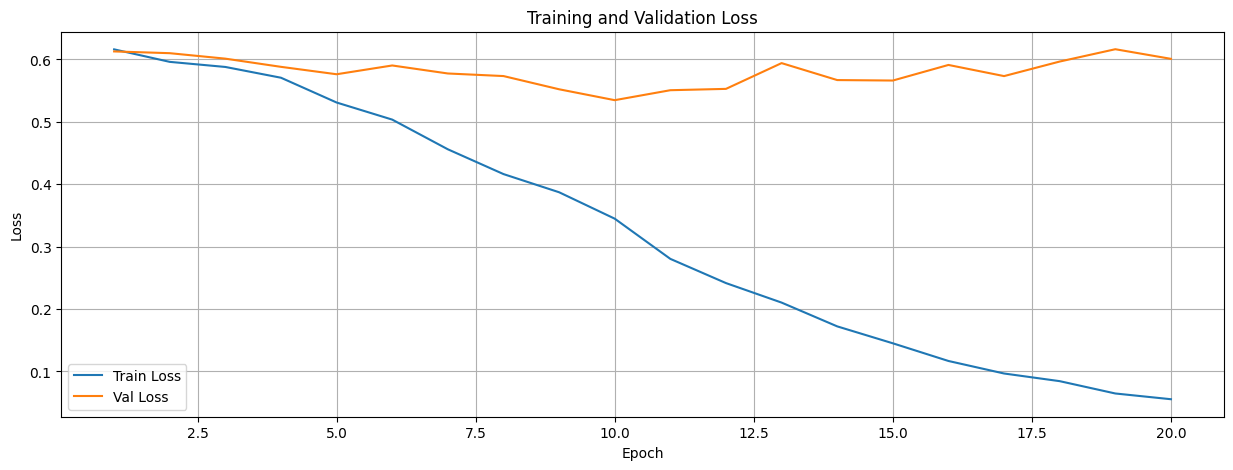

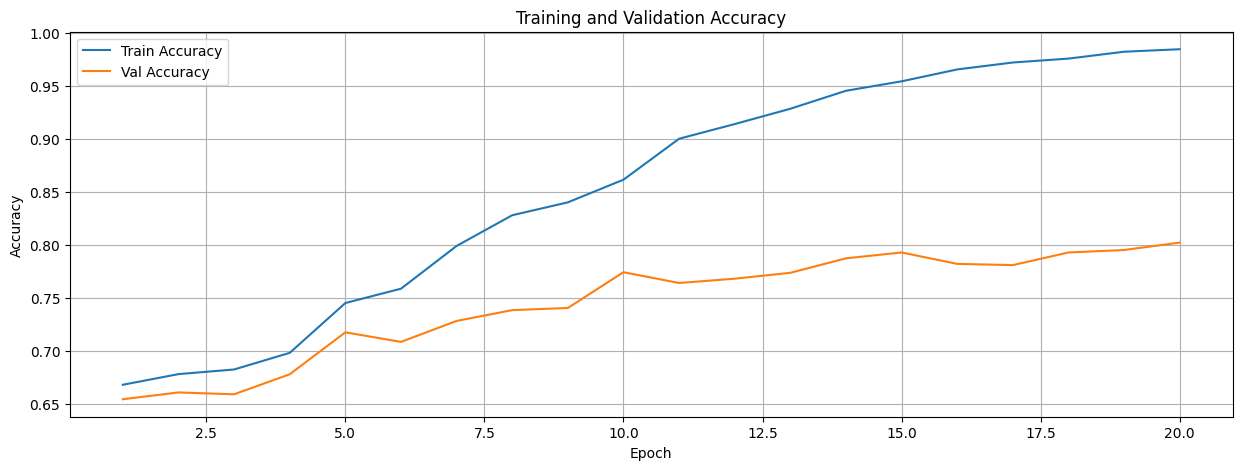

In [25]:
metrics_df = pd.DataFrame(metrics)

# Plot training and validation loss
plt.figure(figsize=(15, 5))
plt.plot(metrics_df['epoch'], metrics_df['train_loss'], label='Train Loss')
plt.plot(metrics_df['epoch'], metrics_df['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(15, 5))
plt.plot(metrics_df['epoch'], metrics_df['train_accuracy'], label='Train Accuracy')
plt.plot(metrics_df['epoch'], metrics_df['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
import torch
import numpy as np
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
                            cohen_kappa_score, roc_auc_score, balanced_accuracy_score,
                            matthews_corrcoef, log_loss, brier_score_loss,
                            confusion_matrix, classification_report, jaccard_score)
from tabulate import tabulate
from tqdm.auto import tqdm


model.eval()
test_predictions = []
test_labels = []
test_probs = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating on Test Set", leave=False):
        labels = batch.pop('labels').to(device)
        batch = {k: v.to(device) for k, v in batch.items()}
        logits = model(**batch)

        probs = torch.softmax(logits, dim=1).cpu().numpy()
        _, predicted = torch.max(logits, 1)

        test_predictions.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        test_probs.extend(probs)

# Convert lists to numpy arrays
test_predictions = np.array(test_predictions)
test_labels = np.array(test_labels)
test_probs = np.array(test_probs)

# Compute metrics
accuracy = accuracy_score(test_labels, test_predictions)
balanced_acc = balanced_accuracy_score(test_labels, test_predictions)
f1_weighted = f1_score(test_labels, test_predictions, average='weighted')
f1_macro = f1_score(test_labels, test_predictions, average='macro')
f1_micro = f1_score(test_labels, test_predictions, average='micro')
precision_weighted = precision_score(test_labels, test_predictions, average='weighted')
recall_weighted = recall_score(test_labels, test_predictions, average='weighted')
kappa = cohen_kappa_score(test_labels, test_predictions)
mcc = matthews_corrcoef(test_labels, test_predictions)
jaccard = jaccard_score(test_labels, test_predictions, average='weighted')

# ROC AUC and Log Loss
if len(np.unique(test_labels)) == 2:
    roc_auc = roc_auc_score(test_labels, test_probs[:, 1])
    logloss = log_loss(test_labels, test_probs[:, [0, 1]])
    brier = brier_score_loss(test_labels, test_probs[:, 1])
else:
    roc_auc = roc_auc_score(test_labels, test_probs, multi_class='ovr', average='weighted')
    logloss = log_loss(test_labels, test_probs)
    brier = None  

# Confusion matrix and per-class metrics
cm = confusion_matrix(test_labels, test_predictions)
class_report = classification_report(test_labels, test_predictions, output_dict=True)

# Print tabulated metrics
metrics_table = [
    ["Accuracy", f"{accuracy:.4f}"],
    ["Balanced Accuracy", f"{balanced_acc:.4f}"],
    ["F1 Score (Weighted)", f"{f1_weighted:.4f}"],
    ["F1 Score (Macro)", f"{f1_macro:.4f}"],
    ["F1 Score (Micro)", f"{f1_micro:.4f}"],
    ["Precision (Weighted)", f"{precision_weighted:.4f}"],
    ["Recall (Weighted)", f"{recall_weighted:.4f}"],
    ["Cohen's Kappa", f"{kappa:.4f}"],
    ["Matthews Correlation Coefficient", f"{mcc:.4f}"],
    ["Jaccard Score (Weighted)", f"{jaccard:.4f}"],
    ["ROC AUC (Weighted)", f"{roc_auc:.4f}"],
    ["Log Loss", f"{logloss:.4f}"],
]
if brier is not None:
    metrics_table.append(["Brier Score", f"{brier:.4f}"])

print("\nTest Set Classification Metrics:")
print(tabulate(metrics_table, headers=['Metric', 'Score'], tablefmt='grid'))

Evaluating on Test Set:   0%|          | 0/431 [00:00<?, ?it/s]


Test Set Classification Metrics:
+----------------------------------+---------+
| Metric                           |   Score |
+==================================+=========+
| Accuracy                         |  0.8196 |
+----------------------------------+---------+
| Balanced Accuracy                |  0.8195 |
+----------------------------------+---------+
| F1 Score (Weighted)              |  0.8195 |
+----------------------------------+---------+
| F1 Score (Macro)                 |  0.8195 |
+----------------------------------+---------+
| F1 Score (Micro)                 |  0.8196 |
+----------------------------------+---------+
| Precision (Weighted)             |  0.8202 |
+----------------------------------+---------+
| Recall (Weighted)                |  0.8196 |
+----------------------------------+---------+
| Cohen's Kappa                    |  0.6392 |
+----------------------------------+---------+
| Matthews Correlation Coefficient |  0.6398 |
+-------------------------

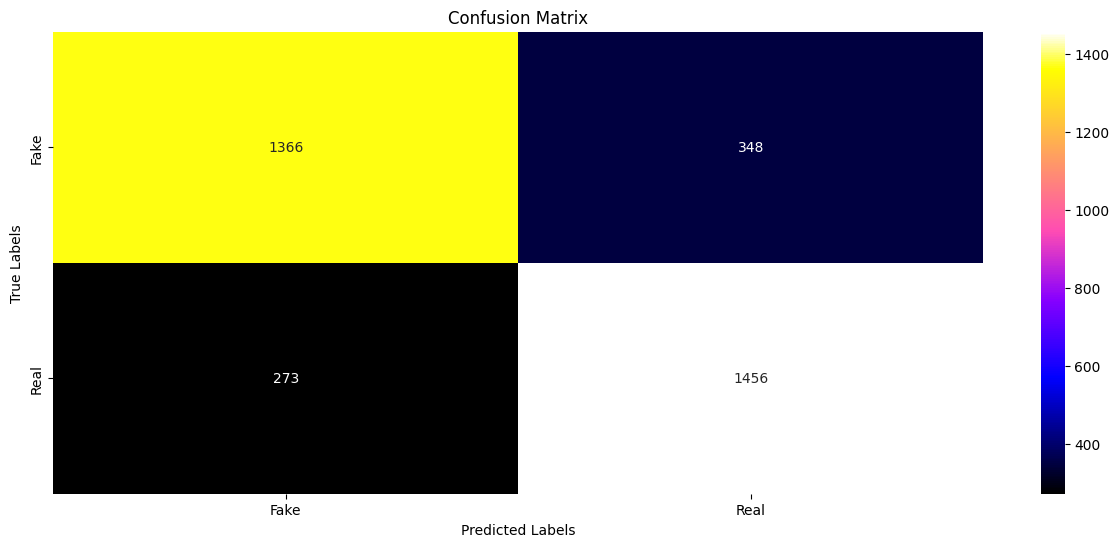

In [27]:
cm = confusion_matrix(test_labels,test_predictions)
plt.figure(figsize=(15, 6))
label_name=["Fake","Real"]
sns.heatmap(cm, annot=True, fmt='d', cmap='gnuplot2',xticklabels=label_name,yticklabels=label_name)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [28]:
# Generate classification report as dict
report_dict = classification_report(test_labels, test_predictions, target_names=label_name, output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Optional: round metrics for better readability
report_df = report_df.round(4)

# Print the classification report in a table format
print("\nClassification Report:")
print(tabulate(report_df, headers='keys', tablefmt='grid'))


Classification Report:
+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
+==============+=============+==========+============+===========+
| Fake         |      0.8334 |   0.797  |     0.8148 | 1714      |
+--------------+-------------+----------+------------+-----------+
| Real         |      0.8071 |   0.8421 |     0.8242 | 1729      |
+--------------+-------------+----------+------------+-----------+
| accuracy     |      0.8196 |   0.8196 |     0.8196 |    0.8196 |
+--------------+-------------+----------+------------+-----------+
| macro avg    |      0.8203 |   0.8195 |     0.8195 | 3443      |
+--------------+-------------+----------+------------+-----------+
| weighted avg |      0.8202 |   0.8196 |     0.8195 | 3443      |
+--------------+-------------+----------+------------+-----------+


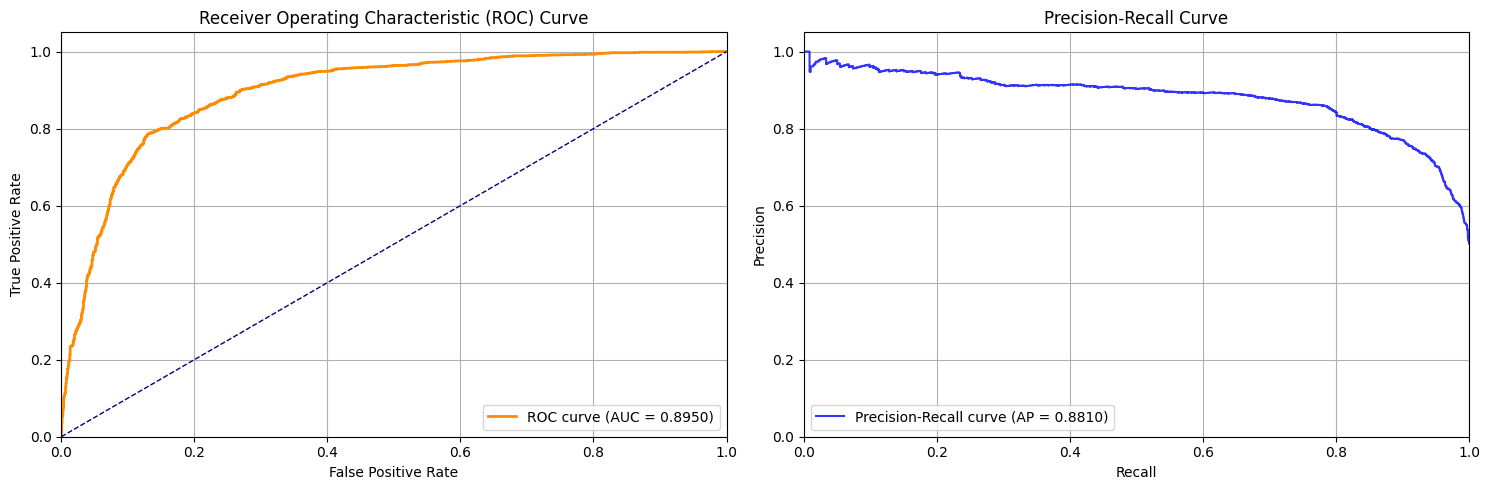

In [29]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

y_true = test_labels
y_scores = test_probs[:, 1]

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(y_true, y_scores)
avg_precision = average_precision_score(y_true, y_scores)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
axs[0].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
axs[0].set_xlim([0.0, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('Receiver Operating Characteristic (ROC) Curve')
axs[0].legend(loc="lower right")
axs[0].grid(True)

axs[1].step(recall, precision, color='b', alpha=0.8, where='post', label=f'Precision-Recall curve (AP = {avg_precision:.4f})')
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlim([0.0, 1.0])
axs[1].set_title('Precision-Recall Curve')
axs[1].legend(loc='lower left')
axs[1].grid(True)

plt.tight_layout()
plt.show()


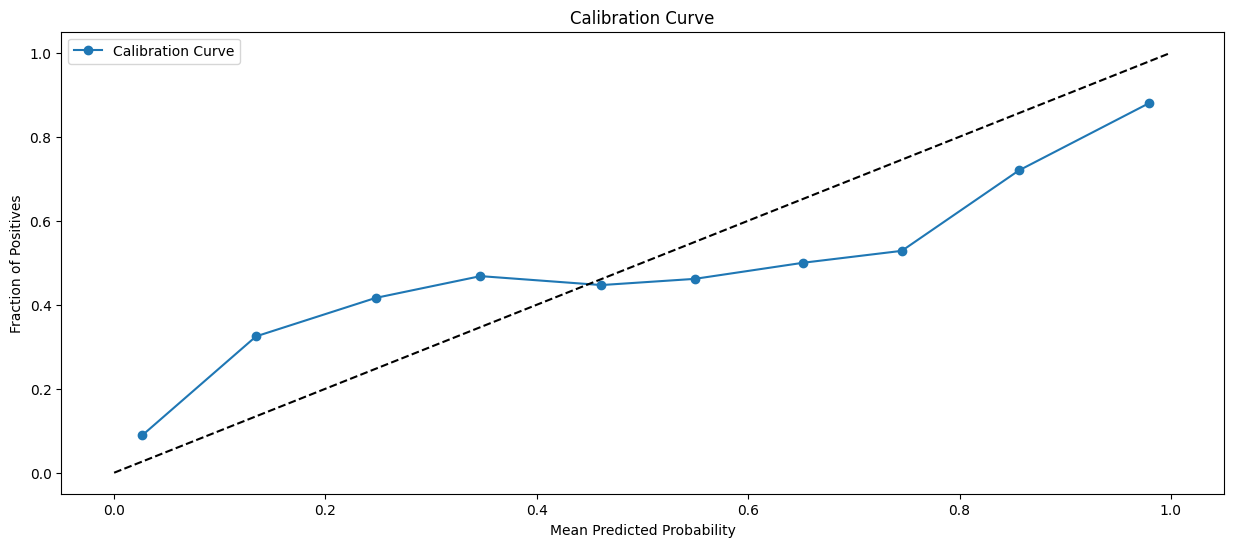

In [30]:
from sklearn.calibration import calibration_curve

n_classes = len(np.unique(test_labels))

if n_classes == 2:
    prob_true, prob_pred = calibration_curve(test_labels, test_probs[:, 1], n_bins=10)
    plt.figure(figsize=(15, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Calibration Curve')
    plt.legend()
    plt.show()

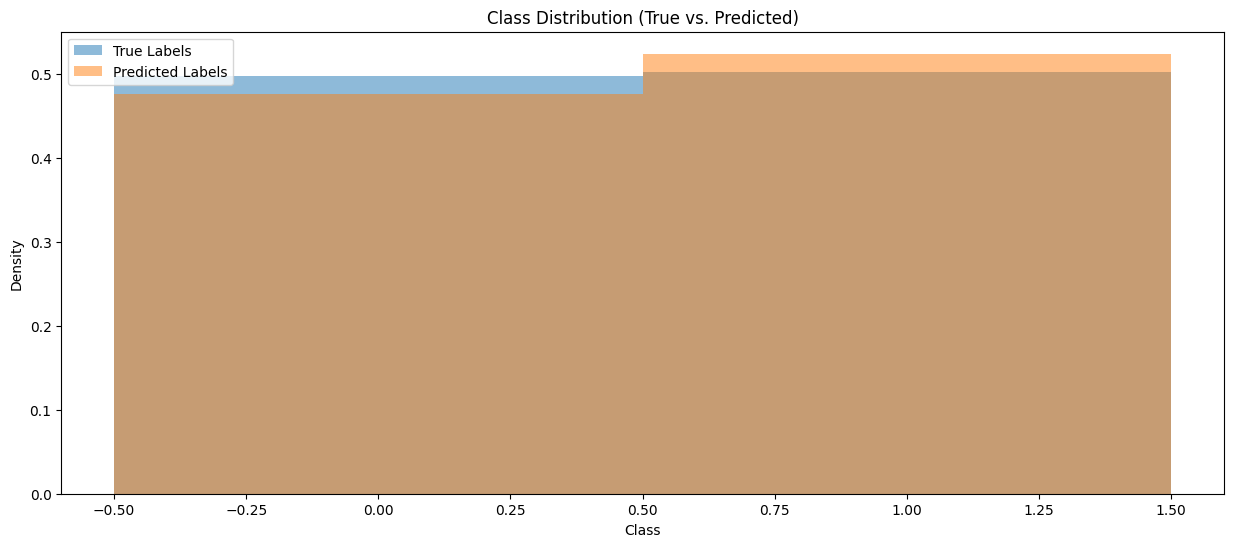

In [31]:
plt.figure(figsize=(15, 6))
plt.hist(test_labels, bins=np.arange(n_classes + 1) - 0.5, alpha=0.5, label='True Labels', density=True)
plt.hist(test_predictions, bins=np.arange(n_classes + 1) - 0.5, alpha=0.5, label='Predicted Labels', density=True)
plt.xlabel('Class')
plt.ylabel('Density')
plt.title('Class Distribution (True vs. Predicted)')
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


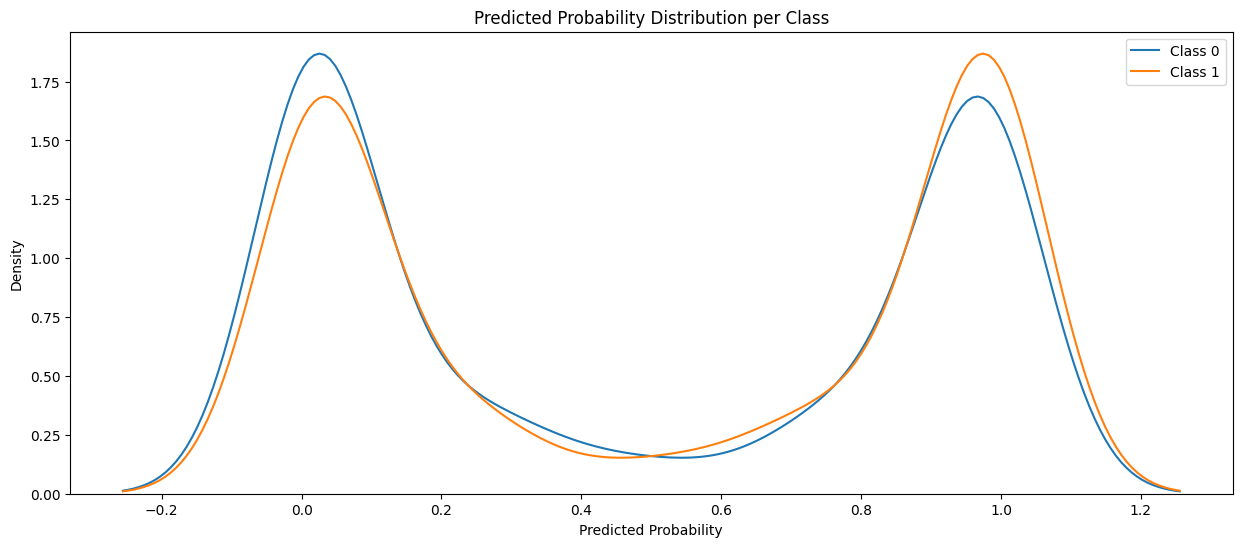

In [32]:
plt.figure(figsize=(15, 6))
for i in range(n_classes):
    sns.kdeplot(test_probs[:, i], label=f'Class {i}')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title('Predicted Probability Distribution per Class')
plt.legend()
plt.show()

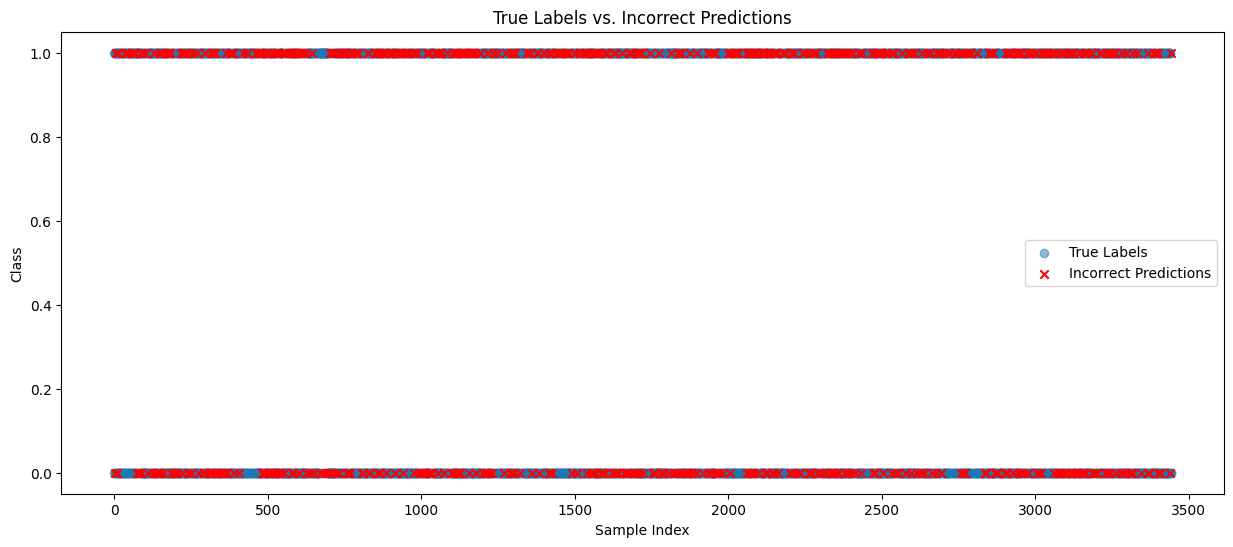

In [33]:
errors = test_predictions != test_labels
error_indices = np.where(errors)[0]
plt.figure(figsize=(15, 6))
plt.scatter(range(len(test_labels)), test_labels, alpha=0.5, label='True Labels')
plt.scatter(error_indices, test_predictions[errors], c='red', label='Incorrect Predictions', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.title('True Labels vs. Incorrect Predictions')
plt.legend()
plt.show()

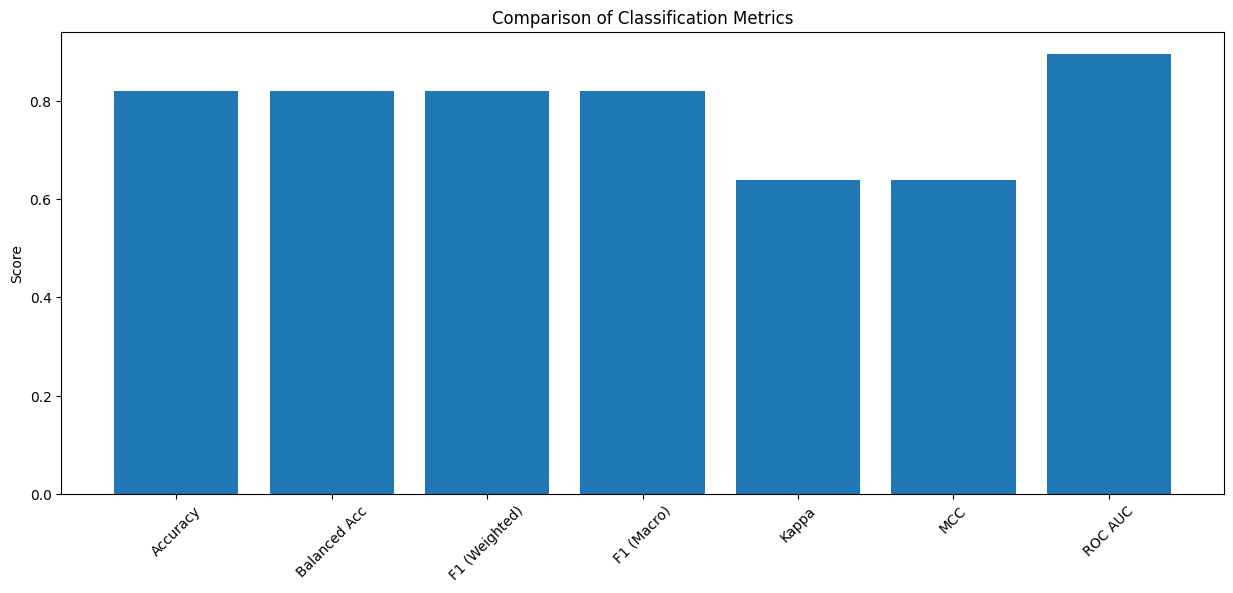

In [34]:
metrics = {'Accuracy': accuracy, 'Balanced Acc': balanced_acc, 'F1 (Weighted)': f1_weighted,
           'F1 (Macro)': f1_macro, 'Kappa': kappa, 'MCC': mcc, 'ROC AUC': roc_auc}
plt.figure(figsize=(15, 6))
plt.bar(metrics.keys(), metrics.values())
plt.title('Comparison of Classification Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()

In [35]:

class_names = {0: 'fake', 1: 'real'}

text_images, text_input_ids, text_labels = [], [], []
image_pixel_values, image_input_ids, image_labels = [], [], []
text_count, image_count = 0, 0

for batch in test_loader:
    batch_images = batch['pixel_values']
    batch_input_ids = batch['input_ids']
    batch_labels = batch['labels'].numpy()
    
    for img, input_id, label in zip(batch_images, batch_input_ids, batch_labels):
        if text_count < 35:
            text_images.append(img)  # Keep image for compatibility, will zero out if needed
            text_input_ids.append(input_id)
            text_labels.append(label)
            text_count += 1
        elif image_count < 30:
            image_pixel_values.append(img)
            image_input_ids.append(input_id) 
            image_labels.append(label)
            image_count += 1
        if text_count >= 35 and image_count >= 30:
            break
    if text_count >= 35 and image_count >= 30:
        break

# Model evaluation
model.eval()
all_pred_labels, all_probs, all_true_labels = [], [], []
all_content = []


if text_input_ids:
    with torch.no_grad():
        pixel_values = torch.zeros_like(torch.stack(text_images)).to(device)  # Zeroed images
        input_ids = torch.stack(text_input_ids).to(device)
        attention_mask = (input_ids != 0).float().to(device)
        batch = {'pixel_values': pixel_values, 'input_ids': input_ids, 'attention_mask': attention_mask}
        
        logits = model(**batch)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        pred_labels = torch.argmax(logits, dim=1).cpu().numpy()
        
        all_pred_labels.extend(pred_labels)
        all_probs.extend(probs)
        all_true_labels.extend(text_labels)
        
       
        decoded_texts = processor.tokenizer.batch_decode(text_input_ids, skip_special_tokens=True)
        for idx, text in enumerate(decoded_texts):
            if not all(ord(c) < 128 for c in text):
                decoded_texts[idx] = text.encode().decode('utf-8', errors='replace')
            all_content.append(f"Text {idx}: {decoded_texts[idx][:50] + '...' if len(decoded_texts[idx]) > 50 else decoded_texts[idx]}")


if image_pixel_values:
    with torch.no_grad():
        pixel_values = torch.stack(image_pixel_values).to(device)
        input_ids = torch.zeros_like(torch.stack(image_input_ids)).to(device)  # Zeroed input_ids
        attention_mask = torch.zeros_like(input_ids).to(device)
        batch = {'pixel_values': pixel_values, 'input_ids': input_ids, 'attention_mask': attention_mask}
        
        logits = model(**batch)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        pred_labels = torch.argmax(logits, dim=1).cpu().numpy()
        
        all_pred_labels.extend(pred_labels)
        all_probs.extend(probs)
        all_true_labels.extend(image_labels)
        
        # Add image placeholders
        for idx in range(len(image_pixel_values)):
            all_content.append(f"Image {idx}")

# Create table
table_data = []
for idx in range(65):
    pred_label = class_names[all_pred_labels[idx]]
    true_label = class_names[all_true_labels[idx]]
    confidence = np.max(all_probs[idx])
    color = '\033[92m' if pred_label == true_label else '\033[91m'
    reset_color = '\033[0m'
    
    row = [
        f"{color}Pred: {pred_label}{reset_color}",
        f"{color}True: {true_label}{reset_color}",
        f"{color}Conf: {confidence:.2f}{reset_color}",
        all_content[idx]
    ]
    table_data.append(row)

# Print table
table = tabulate(table_data, headers=["Predicted", "True Label", "Confidence", "Content"], 
                 tablefmt="fancy_grid", numalign="center")
print(table)

╒═════════════╤══════════════╤══════════════╤════════════════════════════════════════════════════════════════╕
│ Predicted   │ True Label   │ Confidence   │ Content                                                        │
╞═════════════╪══════════════╪══════════════╪════════════════════════════════════════════════════════════════╡
│ Pred: fake  │ True: fake   │ Conf: 0.97   │ Text 0: ল ু ক া ন ো প া ন ি খ া ওয ়া ল ু ঙ ্ গ ি ম ু খ ম ...              │
├─────────────┼──────────────┼──────────────┼────────────────────────────────────────────────────────────────┤
│ Pred: fake  │ True: real   │ Conf: 0.97   │ Text 1: স ্ বপ ্ ন সঠ ি ক ইঙ ্ গ ি ত ল া ভ আমল চ ি ন ্ ত া...           │
├─────────────┼──────────────┼──────────────┼────────────────────────────────────────────────────────────────┤
│ Pred: fake  │ True: fake   │ Conf: 1.00   │ Text 2: ct gov malloy instruct school superintendent to fo...  │
├─────────────┼──────────────┼──────────────┼──────────────────────────────────────────────

In [36]:
processor_save_directory = "./clip_processor"
os.makedirs(processor_save_directory, exist_ok=True)
processor.save_pretrained(processor_save_directory)

import shutil
# Source directory to zip
source_dir = "/kaggle/working/clip_processor"

# Output zip file path (without .zip extension)
zip_file = "/kaggle/working/clip_processor_zip"

# Create zip file
shutil.make_archive(zip_file, 'zip', source_dir)

print(f"Zipped folder saved to: {zip_file}.zip")

Zipped folder saved to: /kaggle/working/clip_processor_zip.zip


In [37]:
import torch
import os

# Create the clip_model folder (if it doesn't exist)
os.makedirs("/kaggle/working/clip_model", exist_ok=True)

# Define the path for the .pth file inside clip_model/
model_path = os.path.join("/kaggle/working/clip_model", "trained_model.pth")

# Save your full trained model's state dict
torch.save(model.state_dict(), model_path)

print(f"✅ Trained model saved to: {model_path}")


✅ Trained model saved to: /kaggle/working/clip_model/trained_model.pth


In [38]:
save_dir = "/kaggle/working/clip_classifier_hf"
os.makedirs(save_dir, exist_ok=True)

model.clip.save_pretrained(save_dir)


In [39]:
! pip freeze

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


absl-py==1.4.0
accelerate==1.8.1
aiofiles==22.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.12.13
aiosignal==1.3.2
aiosqlite==0.21.0
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.1
alembic==1.16.2
altair==5.5.0
annotated-types==0.7.0
annoy==1.17.3
ansicolors==1.1.8
antlr4-python3-runtime==4.9.3
anyio==4.9.0
argon2-cffi==25.1.0
argon2-cffi-bindings==21.2.0
args==0.1.0
array_record==0.7.2
arrow==1.3.0
arviz==0.21.0
astropy==7.1.0
astropy-iers-data==0.2025.6.23.0.39.50
asttokens==3.0.0
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
bayesian-optimization==3.0.0
beartype==0.21.0
beautifulsoup4==4.13.4
betterproto==2.0.0b6
bigframes==2.8.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blobfile==3.0.0
blosc2==3.5.0
bokeh==3.7.3
Boruta==0.4.3
boto3==1.39.1
botocore==1.39.1
Bottleneck==1.4.2
-e git+https://github.com/SohierDane/BigQuery_Helper@8615a7f6c1663e7f2d48aa2b32c2dbcb